# Khám phá dữ liệu **HR Analytics: Job Change of Data Scientists**

# Load data

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
with open('../data/raw/aug_train.csv','r') as file:
    col_names = file.readline().strip().split(',')
data = np.genfromtxt('../data/raw/aug_train.csv', delimiter=',', 
                     dtype=str, skip_header=1)


# Basic Information

In [42]:
num_rows, num_cols = data.shape
print(f'Số hàng: {num_rows}')
print(f'Số cột: {num_cols}')
print('Danh sách cột:')
for i in range(len(col_names)):
    print(f'{i + 1}. {col_names[i]}')
print(f'Overall size:{num_rows * num_cols}')
print('Ý nghĩa: Mỗi dòng đại diện cho 1 ứng viên đang có muốn đổi việc hay không')


Số hàng: 19158
Số cột: 14
Danh sách cột:
1. enrollee_id
2. city
3. city_development_index
4. gender
5. relevent_experience
6. enrolled_university
7. education_level
8. major_discipline
9. experience
10. company_size
11. company_type
12. last_new_job
13. training_hours
14. target
Overall size:268212
Ý nghĩa: Mỗi dòng đại diện cho 1 ứng viên đang có muốn đổi việc hay không


# Data Integrity

In [43]:
unique = np.unique(data[:,col_names.index('enrollee_id')])
print(f'Số giá trị unique: {len(unique)}')


Số giá trị unique: 19158


Có vẻ như không có hàng nào trùng lặp vậy ta không cần xóa

# Column Inventory

**Columns**:

`enrollee_id` : Unique ID for candidate.\
`city`: City code.\
`city_ development _index` : Developement index of the city (scaled).\
`gender`: Gender of candidate\
`relevent_experience`: Relevant experience of candidate\
`enrolled_university`: Type of University course enrolled if any\
`education_level`: Education level of candidate\
`major_discipline` :Education major discipline of candidate\
`experience`: Candidate total experience in years\
`company_size`: No of employees in current employer's company\
`company_type` : Type of current employer\
`last_new_job`: Difference in years between previous job and current job\
`training_hours`: training hours completed\
`target`: 0 – Not looking for job change, 1 – Looking for a job change

### Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

Các cột `enrollee_id`,`city`, `gender`, `relevent_experience`, `major_discipline`, `company_type`: kiểu dữ liệu dạng chuỗi là hoàn toàn đúng rồi\
Cột `enrolled_university`, `education_level`, `experience`, `company_size`, `last_new_job`: hiện vẫn là chuỗi nhưng có thứ tự rõ ràng, tạm thời để chuỗi cũng được, có gì cần thì ta sẽ map thành ordinal sau\
Các cột `city_development_index`,`training_hours`, `target`: hiện đang là chuỗi → cần chuyển ngay từ kiểu dữ liệu dạng chuỗi sang numeric (float/int); để có thể tiếp tục khám phá 

## Tiền xử lí

In [44]:
data_num = data.copy()
data_num[data_num == ''] = np.nan
city_dev_index = data_num[:,2].astype(float)
training_hours = data_num[:,12].astype(float)
target = data_num[:,13].astype(float)

### Với mỗi cột có kiểu dữ liệu dạng số (numeric) và dạng datetime, các giá trị được phân bố như thế nào?

In [53]:
print("=== CÁC CỘT DỮ LIỆU DẠNG SỐ (NUMERIC) ===\n")
print(f"{'Tên cột':<25} {'Missing':<8} {'Min':<8} {'Max':<8} {'Mean':<8}")
print("-" * 60)

# 3 cột số
numeric_info = [
    (col_names.index('city_development_index'),  "city_development_index"),
    (col_names.index('training_hours'), "training_hours"),
    (col_names.index('target'), "target")
]

for idx, name in numeric_info:
    col = data[:, idx]
    col_float = data_num[:,idx].astype(float)
    missing = np.sum(col == '')
    mean_val = np.nanmean(col_float)
    min_val = np.nanmin(col_float)
    max_val = np.nanmax(col_float)
    print(f"{name:<25} {missing:<8} {min_val:<8.3f} {max_val:<8.3f} {mean_val:<8.3f}")

=== CÁC CỘT DỮ LIỆU DẠNG SỐ (NUMERIC) ===

Tên cột                   Missing  Min      Max      Mean    
------------------------------------------------------------
city_development_index    0        0.448    0.949    0.829   
training_hours            0        1.000    336.000  65.367  
target                    0        0.000    1.000    0.249   


### Với mỗi cột có kiểu dữ liệu dạng phân loại (categorical), các giá trị được phân bố như thế nào? 

In [59]:
print("\n\n=== CÁC CỘT DỮ LIỆU DẠNG CATEGORICAL ===\n")
print(f"{'Tên cột':<22} {'Missing(%)':<10} {'Unique':<8} {'Ví dụ phổ biến'}")
print("-" * 70)
for idx, name in enumerate(col_names):
    if name in ['city_development_index','training_hours','target']:
        continue
    col = data[:, idx]
    missing = np.sum(col == '') * 100.0/ len(data)
    valid_values = col[col != '']
    vals, counts = np.unique(valid_values, return_counts=True)
    top_idx = np.argsort(-counts)[:4]
    examples = ", ".join(vals[top_idx])
    print(f"{name:<22} {missing:<10.2f} {len(vals):<8} {examples}")



=== CÁC CỘT DỮ LIỆU DẠNG CATEGORICAL ===

Tên cột                Missing(%) Unique   Ví dụ phổ biến
----------------------------------------------------------------------
enrollee_id            0.00       19158    9987, 9986, 9985, 9984
city                   0.00       123      city_103, city_21, city_16, city_114
gender                 23.53      3        Male, Female, Other
relevent_experience    0.00       2        Has relevent experience, No relevent experience
enrolled_university    2.01       3        no_enrollment, Full time course, Part time course
education_level        2.40       5        Graduate, Masters, High School, Phd
major_discipline       14.68      6        STEM, Humanities, Other, Business Degree
experience             0.34       22       >20, 5, 4, 3
company_size           30.99      8        50-99, 100-500, 10000+, 10/49
company_type           32.05      6        Pvt Ltd, Funded Startup, Public Sector, Early Stage Startup
last_new_job           2.21       6    

## Câu hỏi 1: Tỷ lệ ứng viên muốn thay đổi việc làm có khác biệt theo education_level không?

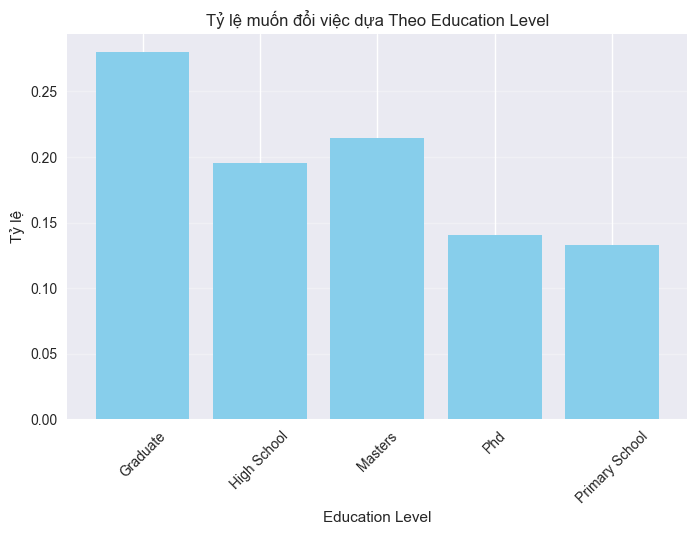

In [46]:
edu_levels = np.unique(data[:, col_names.index('education_level')][data[:, col_names.index('education_level')] != ''])
ratios = []
for level in edu_levels:
    mask  = (data[:,col_names.index('education_level')] == level)
    ratio = np.mean(target[mask] == 1) 
    ratios.append(ratio)

plt.figure(figsize=(8, 5))
plt.bar(edu_levels, ratios, color='skyblue')
plt.xlabel('Education Level')
plt.ylabel('Tỷ lệ')
plt.title('Tỷ lệ muốn đổi việc dựa Theo Education Level')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.show()

### Nhận xét
Nhóm "Graduate" dẫn đầu ở mức 28%, cho thấy gần 1/4 những người có bằng cử nhân mong muốn thay đổi việc làm, phản ánh một lực lượng lao động năng động . Ngược lại, nhóm "Phd" (14.01%) và "Primary School" (13.31%) thể hiện sự ổn định cao, có lẽ do đã đạt vị trí phù hợp hoặc thiếu động lực thay đổi. Nhóm "Masters" (21.44%) và "High School" (19.53%) nằm ở giữa, với "Masters" cho thấy chút ưu thế về ý định thay đổi. Xu hướng này nhấn mạnh rằng trình độ "Graduate" là điểm nóng cần chú ý, trong khi các nhóm khác ít biến động hơn.

## Câu hỏi 2: `city_development_index` ảnh hưởng đến `target` như thế nào?


Mean city_dev_index: Target = 0: 0.85, Target = 1: 0.76


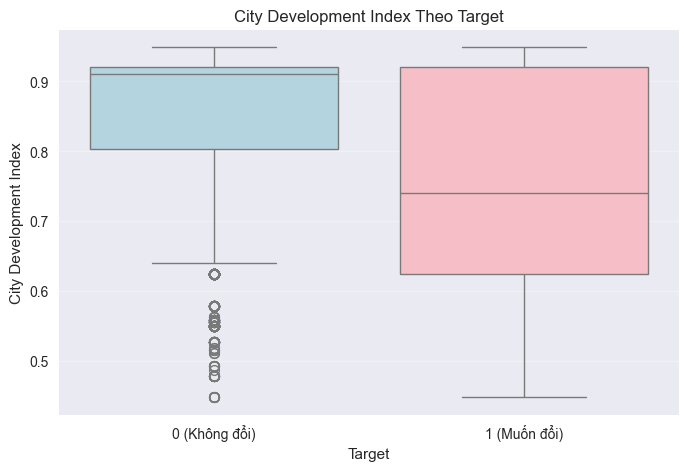

In [47]:
# Câu hỏi 2: City Development Index vs Target
mean_dev_0 = np.mean(city_dev_index[target == 0])
mean_dev_1 = np.mean(city_dev_index[target == 1])
print(f"Mean city_dev_index: Target = 0: {mean_dev_0:.2f}, Target = 1: {mean_dev_1:.2}")

plt.figure(figsize=(8, 5))
sns.boxplot(x=target, y=city_dev_index, hue=target, palette=['lightblue', 'lightpink'], legend=False)
plt.xlabel('Target')
plt.ylabel('City Development Index')
plt.title('City Development Index Theo Target')
plt.xticks([0, 1], ['0 (Không đổi)', '1 (Muốn đổi)'])
plt.grid(True, axis='y', alpha=0.3)
plt.show()

### Nhận xét
- "Sự khác biệt trong city_development_index trung bình (0.85 so với 0.76) cho thấy môi trường đô thị là một yếu tố dự báo quan trọng cho ý định dịch chuyển nghề nghiệp.

- Dữ liệu cho thấy rõ, nhóm 'Không đổi' (Target 0) phần lớn đến từ các thành phố phát triển cao, nơi cơ hội và hạ tầng có thể đủ sức 'giữ chân' họ. Trong khi đó, nhóm 'Muốn đổi' (Target 1) lại có mức CDI trung bình thấp hơn hẳn, hé lộ một thực tế: sự kém phát triển của thành phố đang trực tiếp nuôi dưỡng mong muốn tìm kiếm sự thay đổi. Đây là một chỉ số quan trọng cho thấy sự bất mãn về cơ hội tại nơi ở hiện tại."

## Câu hỏi 3: Tỷ lệ thay đổi việc làm khác nhau như thế nào ở số năm kinh nghiệm?

Text(0, 0.5, 'Tỷ lệ target = 1.0')

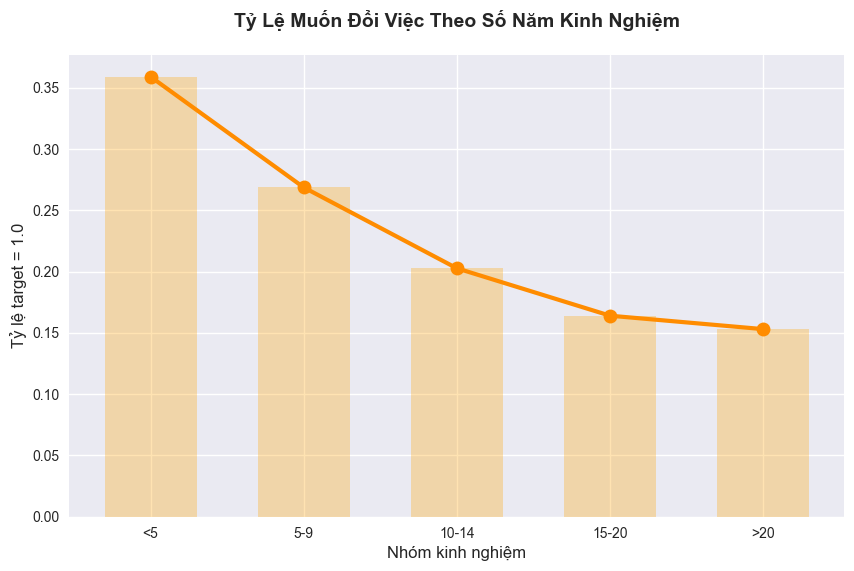

In [48]:
experience = data[:,col_names.index('experience')]
target_valid = target[experience != '']
exp_num = experience[experience != '']
exp_num[exp_num  == '>20'] = 21
exp_num[exp_num  == '<1'] = 0
exp_num = exp_num.astype(float)
bins = [0,5,10,15,21,30]
labels = ['<5','5-9','10-14','15-20','>20']
groups = np.digitize(exp_num,bins) - 1
ratios = []
# ex_target = []
for i in range(5):
    mask = groups == i
    if np.sum(mask) > 0:
        ratio = np.mean(target_valid[mask])
    else:
        ratio = 0
    ratios.append(ratio)
    # ex_target.append(np.sum(target_valid[mask]))

plt.figure(figsize=(10,6))
plt.plot(labels, ratios, marker='o', linewidth=3, markersize=10, color='darkorange')
plt.bar(labels, ratios, alpha=0.3, color='orange', width=0.6)

plt.title('Tỷ Lệ Muốn Đổi Việc Theo Số Năm Kinh Nghiệm', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Nhóm kinh nghiệm', fontsize=12)
plt.ylabel('Tỷ lệ target = 1.0', fontsize=12)

# plt.figure(figsize=(10,6))
# plt.pie(ex_target,labels = labels, autopct='%1.1f%%')
# plt.title('Đóng góp thực tế của từng nhóm kinh nghiệm vào tổng số ứng viên muốn đổi việc', fontsize=14, fontweight='bold', pad=20)


Người lao động càng trẻ và càng ít kinh nghiệm (đặc biệt là dưới 5 năm) càng có mong muốn đổi việc cao hơn, có thể do họ đang tìm kiếm sự phù hợp, cơ hội phát triển nhanh chóng, hoặc chưa ổn định sự nghiệp. Ngược lại, những người có kinh nghiệm lâu năm (>15 năm) có xu hướng hài lòng hoặc gắn bó với công việc hiện tại hơn.

## CÂU 4: Thời gian kể từ công việc cuối ảnh hưởng thế nào đến target? Có khác nhau theo education_level?

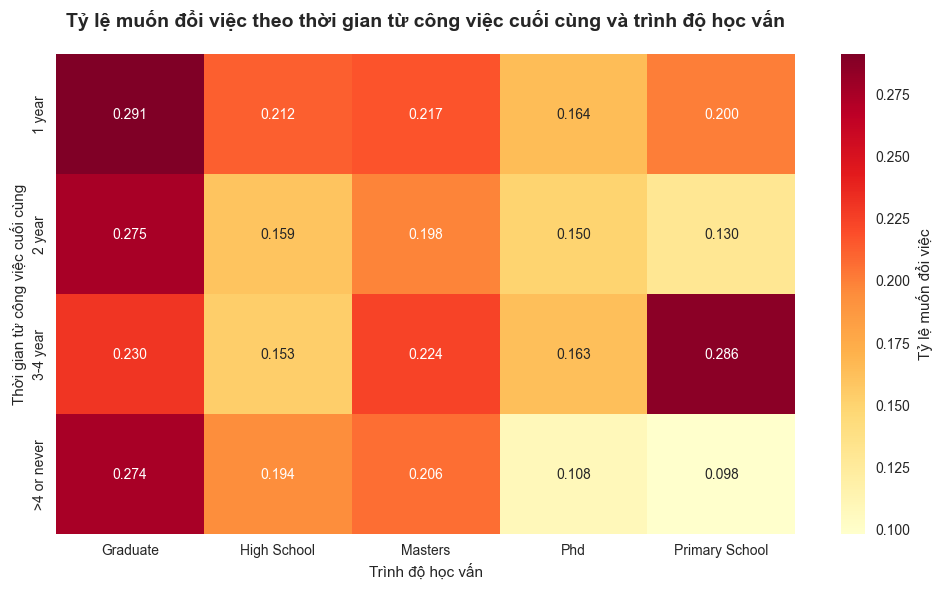

In [49]:
last_job = data[:, col_names.index('last_new_job')]
last_job_num = last_job[last_job != '']
last_job_num[last_job_num == 'never'] = '10'
last_job_num[last_job_num == '>4'] = '5'
last_job_num = last_job_num.astype(float)
# Bước 2: Chia thành 4 nhóm
bins_lj = [0.5, 1.5, 2.5, 4.5, 11]
labels_lj = ['1 year','2 year','3-4 year','>4 or never']
lj_group = np.digitize(last_job_num,bins_lj) - 1
edu_valid = data[:, col_names.index('education_level')][last_job != '']
ratio_matrix = np.zeros((len(labels_lj), len(edu_levels)))

target_lj = target[last_job != '']
for i, lj in enumerate(labels_lj):
    for j,edu in enumerate(edu_levels):
        mask = (lj_group == i) & (edu_valid == edu)
        if mask.sum() > 0:
            ratio_matrix[i,j] = np.mean(target_lj[mask])



# # Bước 5: Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ratio_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=edu_levels, yticklabels=labels_lj,
            cbar_kws={'label': 'Tỷ lệ muốn đổi việc'})
plt.title('Tỷ lệ muốn đổi việc theo thời gian từ công việc cuối cùng và trình độ học vấn', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Trình độ học vấn')
plt.ylabel('Thời gian từ công việc cuối cùng')
plt.tight_layout()
plt.show()



Biểu đồ cho thấy:
Graduate luôn có tỷ lệnh muốn đổi việc cao nhất, bất kể thời gian.
3-4 năm là khoảng thời gian mà tỉ lệ muốn đổi việc cao với hầu hết các nhóm.
Phd gần như không bị ảnh hưởng bởi việc dậm chân tại chỗ.

→ Interaction Graduate × last_new_job là pattern mạnh nhất,có thể khai thác khi modeling.

## CÂU 5: Missing company_size thực chất là nhóm nào? Có phải nhóm ảnh hưởng lớn tới target?


Kết quả sau khi gán thông minh (company_size):
  10/49    → n =  1596 | tỷ lệ muốn đổi việc = 0.2506
  100-500  → n =  3258 | tỷ lệ muốn đổi việc = 0.2115
  1000-4999 → n =  1347 | tỷ lệ muốn đổi việc = 0.1552
  10000+   → n =  3313 | tỷ lệ muốn đổi việc = 0.3049
  50-99    → n =  6810 | tỷ lệ muốn đổi việc = 0.2883
  500-999  → n =   905 | tỷ lệ muốn đổi việc = 0.1768
  5000-9999 → n =   574 | tỷ lệ muốn đổi việc = 0.1847
  <10      → n =  1355 | tỷ lệ muốn đổi việc = 0.1771


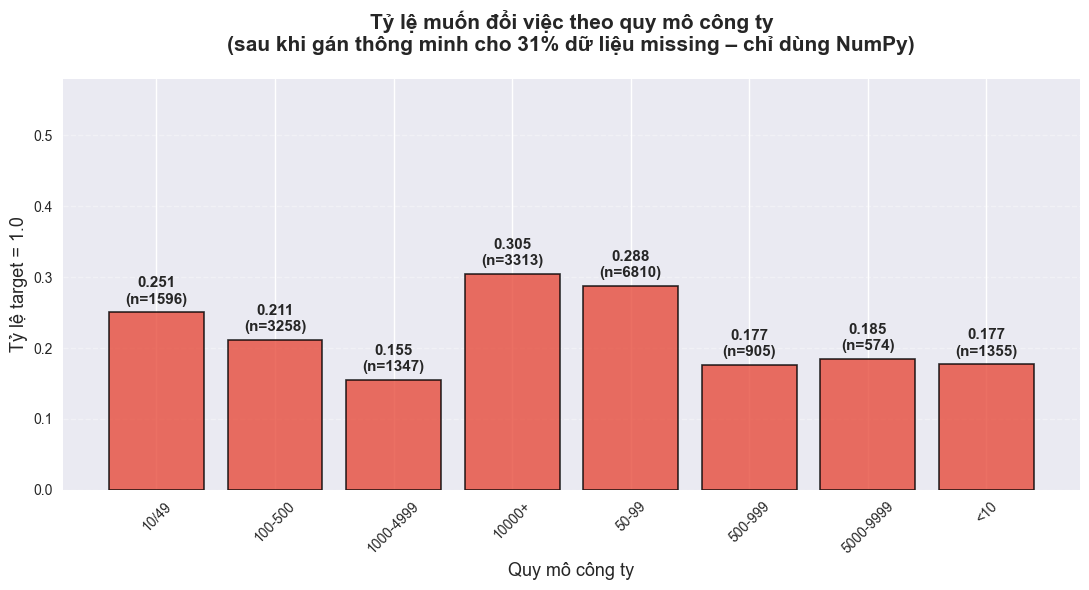

In [61]:
company_size = data[:, col_names.index('company_size')].copy()
city_col     = data[:, col_names.index('city')]
cdi          = city_dev_index  


unique_cities = np.unique(city_col)
size_mode_by_city = {}

for city in unique_cities:
    city_mask = (city_col == city)
    if np.sum(city_mask) <= 10:      # city quá nhỏ → bỏ qua
        continue
    sizes_in_city = company_size[city_mask]
    non_empty = sizes_in_city[sizes_in_city != '']
    if len(non_empty) == 0:
        continue
    values, counts = np.unique(non_empty, return_counts=True)
    mode_value = values[np.argmax(counts)]
    size_mode_by_city[city] = mode_value

# Bước 2: Fill missing company_size – thông minh, chỉ dùng NumPy
# Nếu city có mode → dùng mode đó
# Nếu không → dùng mode toàn cục (tính nhanh bằng np.unique)
global_values, global_counts = np.unique(company_size[company_size != ''], return_counts=True)
global_mode = global_values[np.argmax(global_counts)]   # thường là '<10'

for i in range(len(company_size)):
    if company_size[i] == '':  # missing
        city = city_col[i]
        if city in size_mode_by_city:
            company_size[i] = size_mode_by_city[city]
        else:
            company_size[i] = global_mode   # fallback an toàn

# Bước 3: Tính tỷ lệ target=1 theo từng company_size sau khi fill
unique_sizes = np.unique(company_size)
ratios = []
counts = []

print("\nKết quả sau khi gán thông minh (company_size):")
for size in unique_sizes:
    mask = (company_size == size)
    n = np.sum(mask)
    ratio = np.mean(target[mask])
    ratios.append(ratio)
    counts.append(n)
    print(f"  {size:8} → n = {n:5} | tỷ lệ muốn đổi việc = {ratio:.4f}")

# Bước 4: Vẽ biểu đồ đẹp
plt.figure(figsize=(11, 6))
bars = plt.bar(unique_sizes, ratios, color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.2)

plt.title('Tỷ lệ muốn đổi việc theo quy mô công ty\n'
          '(sau khi gán thông minh cho 31% dữ liệu missing – chỉ dùng NumPy)', 
          fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Quy mô công ty', fontsize=13)
plt.ylabel('Tỷ lệ target = 1.0', fontsize=13)
plt.ylim(0, 0.58)
plt.grid(axis='y', alpha=0.35, linestyle='--')

for i, (bar, r, n) in enumerate(zip(bars, ratios, counts)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008,
             f'{r:.3f}\n(n={n})', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

